## CLASSIC4 STEMMED DATABASE
http://www.dataminingresearch.com/index.php/2010/09/classic3-classic4-datasets/

### Descarga de la colección de textos preprocesada

In [1]:
import os
import classicdb.fetch as fetch

url = "https://sites.google.com/site/xchgdir/public/classic4stem.tar.gz"
classic_home = os.path.join(fetch.get_data_home(), "classic4stem_home")
corpus_root = os.path.join(classic_home, "classic4stem")

In [2]:
print("downloading and extracting file from " + url)
fetch.download_and_unzip(url, classic_home, "classic4stem.tar.gz")
print("downloaded and extracted to " + classic_home)

downloading and extracting file from https://sites.google.com/site/xchgdir/public/classic4stem.tar.gz


downloaded and extracted to C:\Users\lmamani\scikit_learn_data\classic4stem_home


### Parseo y carga en memoria
Sólo leeremos el vocabulario y el número de repeticiones.
- El documento `#1552` no existe en docbyterm.txt

In [3]:
import os

vocabfile = os.path.join(corpus_root, "terms.txt")
docwordfile = os.path.join(corpus_root, "docbyterm.txt")
docfile = os.path.join(corpus_root, "documents.txt")

with open(vocabfile, 'r') as f:
    vocab = [line.strip() for line in f.readlines()]

bagdicts = []
total_dicts_added = 0
with open(docwordfile, 'r') as f:
    for line in f.readlines():
        w = line.strip().split()
        if len(w) == 3:
            docid = int(w[0]) - 1
            wordid = int(w[1]) - 1
            wordcount = int(w[2])
            dicts_added = 0
            while len(bagdicts) <= docid:
                bagdicts.append({})  # add new dictionary
                dicts_added += 1
            if dicts_added > 1:
                print("docids [", docid - dicts_added + 2, ",", docid, "] don't exist")
                total_dicts_added += dicts_added - 1
            dict = bagdicts[docid]
            dict[vocab[wordid]] = wordcount  # add new (vocab[wordid], count) into dictionary
            # dict[wordid] = wordcount  # add new (wordid, count) into dictionary
            
labels = []
doc_labels = ["cacm", "cisi", "cran", "med"]
with open(docfile, 'r') as f:
    for line in f.readlines():
        w = line.strip().split()
        labels.append(doc_labels[int(w[1])]) 

print(len(vocab), "words in vocabulary")
print(len(bagdicts) - total_dicts_added, "documents readed")
print(len(labels), "documents in total")

docids [ 1552 , 1552 ] don't exist


5896 words in vocabulary
7094 documents readed
7095 documents in total


### Conteo de tokens del corpus
- Cada fila representa un documento y está en el orden leído del documento
- Cada columna representa un término y ha sido reordenado (por el Dict)

In [4]:
import numpy as np
from sklearn.feature_extraction import DictVectorizer

vectorizer = DictVectorizer(sparse=False)
count_matrix = vectorizer.fit_transform(bagdicts)
print("cols = frequency by term, row = frequency by file")
print(count_matrix)
print()

for f in range(0, 3):
    print("file #", f, "has", int(np.sum(count_matrix[f])), "terms")
print("...")
print()

print("Some feature terms")
print(vectorizer.get_feature_names()[0:100])

cols = frequency by term, row = frequency by file
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]

file # 0 has 5 terms
file # 1 has 6 terms
file # 2 has 5 terms
...

Some feature terms
['aacr', 'abandon', 'abbrevi', 'abdomen', 'abdomin', 'aberr', 'abl', 'ablat', 'abnorm', 'abolish', 'abort', 'abridg', 'abroad', 'abrupt', 'abruptli', 'abscess', 'abscissa', 'absenc', 'absent', 'absolut', 'absorb', 'absorpt', 'abstract', 'abstractor', 'abund', 'abundantli', 'academ', 'academi', 'acceler', 'accentu', 'accept', 'access', 'accessori', 'accid', 'accident', 'accommod', 'accompani', 'accomplish', 'accord', 'account', 'accredit', 'accret', 'accru', 'accumul', 'accur', 'accuraci', 'acet', 'acetazolamid', 'achiev', 'acid', 'acidosi', 'ackeret', 'acknowledg', 'acm', 'acoust', 'acquaint', 'acquir', 'acquisit', 'acromegali', 'act', 'acth', 'acti', 'a

### Cálculo de matriz TFID

In [5]:
from sklearn.feature_extraction.text import TfidfTransformer

transformer = TfidfTransformer()
tfidf = transformer.fit_transform(count_matrix)

print("TFID matrix:", tfidf.shape)
print(tfidf.toarray())
print()

# print("Weights of each feature computed by TFID")
# print(transformer.idf_)

TFID matrix: (7095, 5896)
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]



### Clusterización y evaluación de la clusterización

In [6]:
from sklearn.cluster import KMeans
from sklearn import metrics

n_clusters = 4

km = KMeans(
    n_clusters=n_clusters,
    init='k-means++',  # or 'random'  
    n_init=100,  # repetition of the process to choose the best
    max_iter=300  # iterations for kmeans
)

print("Document clustering with %s" % km)
km.fit(tfidf)
print()

print("Top terms per cluster:")
order_centroids = km.cluster_centers_.argsort()[:, ::-1]
for i in range(n_clusters):
    print("Cluster %d:" % i, end='')
    for ind in order_centroids[i, :20]:
        print(' %s' % vectorizer.get_feature_names()[ind], end='')
    print()

print("Adjusted Rand-Index: %.3f" % metrics.adjusted_rand_score(labels, km.labels_))
print("Mutual Information based scores: %.3f" % metrics.adjusted_mutual_info_score(labels, km.labels_))
print()

(h, c, v) = metrics.homogeneity_completeness_v_measure(labels, km.labels_)
print("Homogeneity: %0.3f" % h)
print("Completeness: %0.3f" % c)
print("V-measure: %0.3f" % v)
print()

print("Silhouette Coefficient: %0.3f" % metrics.silhouette_score(tfidf, km.labels_, sample_size=1000))
print()

Document clustering with KMeans(copy_x=True, init='k-means++', max_iter=300, n_clusters=4, n_init=100,
    n_jobs=1, precompute_distances='auto', random_state=None, tol=0.0001,
    verbose=0)



Top terms per cluster:
Cluster 0: program comput system languag method problem time gener structur techniqu data present patient cell process paper oper function discuss code
Cluster 1: algorithm function integr matrix polynomi permut gener complex random squar invers exponenti fit solut linear gamma equat number interpol real
Cluster 2: flow boundari layer pressur heat wing number bodi shock solut mach theori equat plate superson effect surfac cylinder temperatur result
Cluster 3: librari inform system retriev index research scienc servic data search book docum scientif user journal base studi develop catalog literatur
Adjusted Rand-Index: 0.368
Mutual Information based scores: 0.533

Homogeneity: 0.534
Completeness: 0.555
V-measure: 0.544



Silhouette Coefficient: 0.018



### Matriz de Confusión

In [25]:
conf_matrix = {}
# fill dictionary
for i, label in enumerate(labels):
    if conf_matrix.get(label) is None:
        conf_matrix[label] = {}
    dict = conf_matrix[label]
    if dict.get(km.labels_[i]) is None:
        dict[km.labels_[i]] = 0
    dict[km.labels_[i]] += 1

print('\t', 0, '\t', 1, '\t', 2, '\t', 3)
for label, dict in conf_matrix.items():
    print(label, end='\t')
    for i in [0, 1, 2, 3]:
        if dict.get(i) is not None:
            count = dict[i]
        else:
            count = 0
        print(count, end='\t')
    print()
print()

print("Posible Matriz de 'Confusión'")
print('\t', 3, '\t', 1, '\t', 2, '\t', 0)
for label, dict in conf_matrix.items():
    print(label, end='\t')
    for i in [3, 1, 2, 0]:
        if dict.get(i) is not None:
            count = dict[i]
        else:
            count = 0
        print(count, end='\t')
    print()

	 0 	 1 	 2 	 3
cisi	287	1	1	1171	
cacm	2057	997	11	139	
cran	197	0	1201	0	
med	1030	0	3	0	

Posible Matriz de 'Confusión'
	 3 	 1 	 2 	 0
cisi	1171	1	1	287	
cacm	139	997	11	2057	
cran	0	0	1201	197	
med	0	0	3	1030	


### Clusters por Categoría
- Los cluster #2, #3 son los más exactos, casi todos sus elementos pertenecen a las categorías CRAN y CISI.
- A pesar de que el cluster #1 tiene todos sus elementos en la categoría CACM, el cluster #0 también tiene elementos en la categoría CACM.
- Esto se puede apreciar mejor en el dendograma donde existen 3 grupos bien diferenciados (1 de ellos está compuesto por 2).

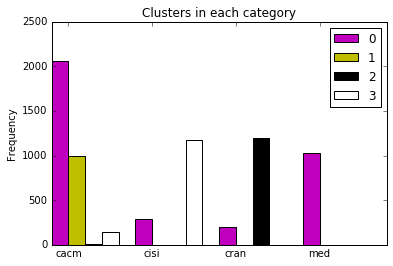

In [17]:
% matplotlib inline

import numpy as np
from matplotlib import pyplot
from numpy import arange

def bar_chart(categories, words, counts, ylabel, title, colors='rgbcmyk', legendloc='upper left'):
    ind = arange(len(words))
    width = 1 / (len(categories) + 1)
    bar_groups = []
    for c in range(len(categories)):
        bars = pyplot.bar(ind + c * width, counts[categories[c]], width, color=colors[c % len(colors)])
        bar_groups.append(bars)
    pyplot.xticks(ind + width, words)
    pyplot.legend([b[0] for b in bar_groups], categories, loc=legendloc)
    pyplot.ylabel(ylabel)
    pyplot.title(title)
    pyplot.show()

clusters = np.unique(km.labels_)
categories = np.unique(labels)

counts = {}
for i, c in enumerate(clusters[0:50]):
    counts[c] = len(categories) * [0]
label_ind = {}
cnt = 0
for i, cat in enumerate(categories):
    label_ind[cat] = cnt
    cnt += 1
for l, label in enumerate(labels):
    counts[km.labels_[l]][label_ind[label]] += 1
bar_chart(clusters, categories, counts, "Frequency", "Clusters in each category", colors='mykw', legendloc='upper right')

### Dendograma

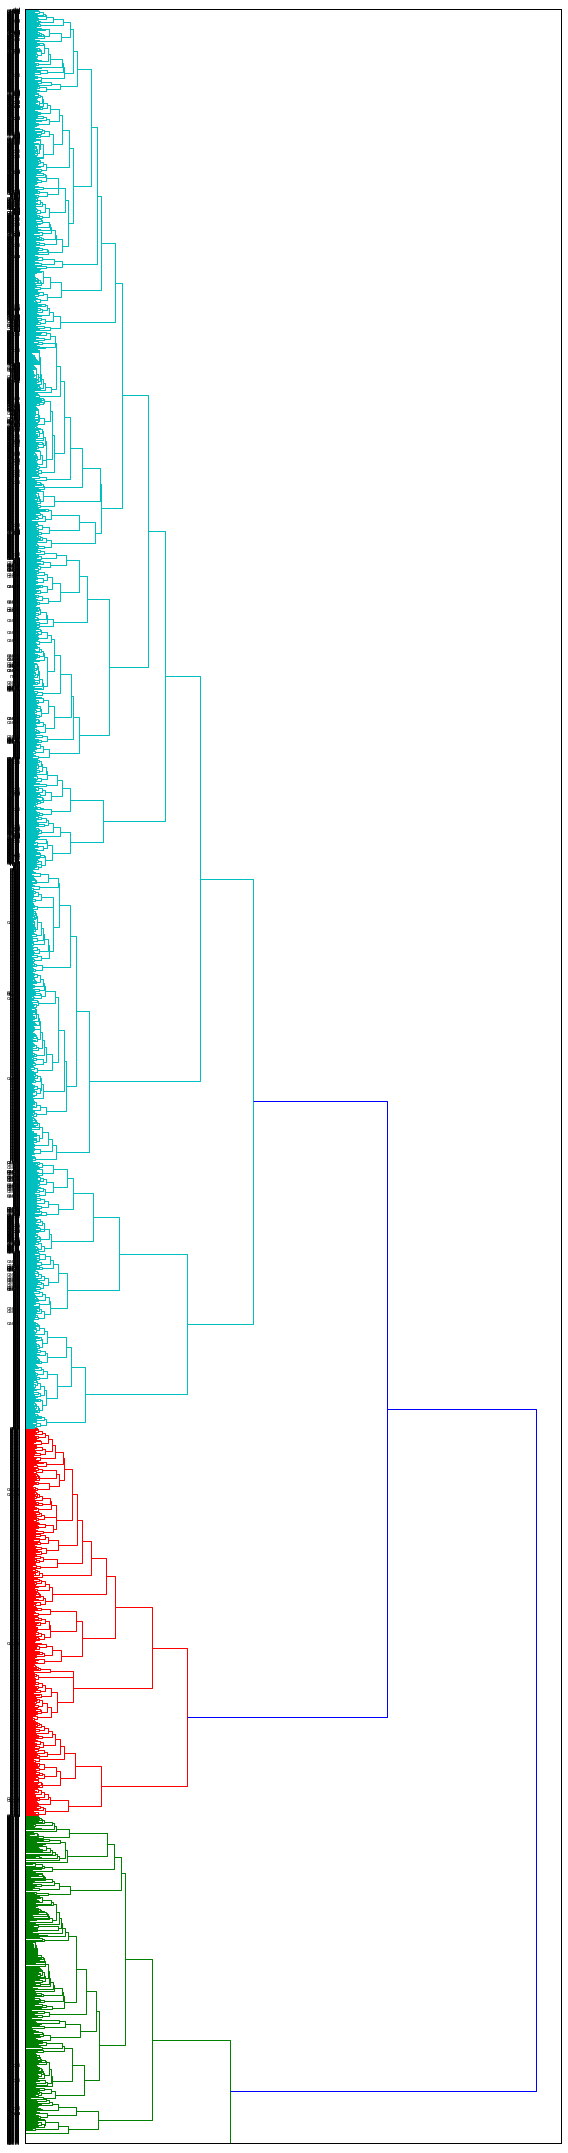

In [27]:
% matplotlib inline

from matplotlib import pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity
from scipy.cluster.hierarchy import ward, dendrogram

dist = 1 - cosine_similarity(tfidf)
linkage_matrix = ward(dist)

fig, ax = plt.subplots(figsize=(8, 30))
ax = dendrogram(linkage_matrix, orientation="right", labels=labels)
plt.tick_params(
    axis='x',  # changes apply to the x-axis
    which='both',  # both major and minor ticks are affected
    bottom='off',  # ticks along the bottom edge are off
    top='off',  # ticks along the top edge are off
    labelbottom='off')

plt.tight_layout()  #show plot with tight layout